# ETUDE DU VIN

## Intro
Nous avons choisit de récupérer une base de données sur les vins du monde. Cette base contient de nombreuses informations telles que le nom du vin, la région d'où il vient, son prix, sa qualité, etc...
Un des objectifs du projet est de savoir si les meilleurs vins sont les plus chèrs. En effet, on peut se demander si le prix est bien fonction de sa qualité. Le prix des vins pourrait etre uniquement lié à la renommée de ceux-ci. 
On propose alors de faire une régression entre le prix et la qualité du vin. 

### Contexte Historique : De la dégustation à la "Data"

Si la viticulture accompagne l'humanité depuis plus de 6 000 ans, la quantification de la qualité du vin est un phénomène beaucoup plus récent. Historiquement, la valeur d'un vin était dictée par des décrets royaux, des classements immuables (comme le classement de Bordeaux de 1855) ou la réputation séculaire d'un terroir.

C'est dans la seconde moitié du XXe siècle, notamment sous l'impulsion de critiques comme Robert Parker, que s'est popularisée l'échelle de notation sur *100* points. Cette "américanisation" de la critique a transformé une expérience subjective et sensorielle en une donnée numérique objective. C'est cette transformation qui rend aujourd'hui possible notre analyse : le goût est devenu une *data exploitable*.

### Pourquoi ce sujet ?

Nous avons choisi ce sujet car le marché du vin représente un terrain de jeu idéal pour la Data Science, au carrefour de l'économie, de la psychologie et de l'agriculture :

1.  *L'opacité du marché :* Pour le consommateur non-expert, il est difficile d'évaluer la qualité d'une bouteille avant de l'ouvrir. Le prix devient souvent le seul signal de qualité perçue.
2.  *La détection des "anomalies" de marché :* L'analyse de données nous permet de dépasser le marketing. En croisant les notes (jugement d'experts à l'aveugle) et les prix, nous pouvons identifier objectivement les vins sous-cotés (les "bons plans") et les vins dont le prix ne se justifie que par l'image de marque.
3.  *L'influence géographique :* Ce jeu de données permet également de vérifier si la "prime de terroir" (payer plus cher pour un vin français ou californien) est statistiquement justifiée par une qualité supérieure dans le verre.

Cellule à lancer pour faire les importations nécessaires : 

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

/Users/meljansevanrensburg/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### I. Nettoyage des données 
Avant de commencer à analyser notre de base de données, on doit nettoyer son contenu. C'est à dire traiter les valeurs manquantes en les supprimant et retirer les doublons pour garantir une analyse fiable et des models pertients. 

Le code suivant permet de faire ceci : 

In [ ]:
csv_file='winemag-data-130k-v2.csv' #nom du fichier

def nettoyage_et_export(csv_file, output_file):

    data = pd.read_csv(csv_file) #lecture du fichier CSV

    print(f"Avant le nettoyage : {len(data)} éléments")

    data_clean = data.dropna(subset=['price', 'points']) #suppression des lignes avec des valeurs manquantes dans les colonnes 'price' et 'points'
    data_clean = data_clean[data_clean['price'] > 0] #suppression des lignes avec des prix négatifs ou nuls

    print(f"Après le nettoyage : {len(data_clean)} éléments")

    data_clean.to_csv(output_file, index=False) #sauvegarde du nouveau fichier CSV
    print(f"Nouveau jeu de données sauvegardé sous : {output_file}")
    
   
nettoyage_et_export(csv_file, 'data_cleaned.csv') #Appel de la fonction de nettoyage et d'exportation

data=pd.read_csv('data_cleaned.csv')


Avant le nettoyage : 129971 éléments
Après le nettoyage : 120975 éléments
Nouveau jeu de données sauvegardé sous : data_cleaned.csv


### II. Analyse exploratoire 
Cette partie sert à comprendre comment sont réparties nos données. Elle permet aussi de savoir si le pays est un facteur à prendre en compte pour déterminer la qualité du vin. Certains pays pourraient proposer des vins chèrs à cause de leur renommée. Enfin,  l'analyse exploratoire permet de vérifier qu'il existe bien un lien entre le prix du vin et sa qualité, avant qu'on lance des calculs pour faire une régression. 
- Loi suivit par les notes : 

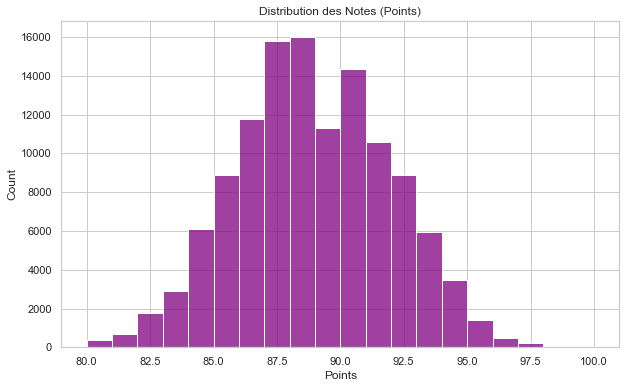

In [ ]:
# Visualisation de la distribution des notes (points)

sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(data['points'], bins=20,  color='purple')
plt.title('Distribution des Notes (Points)')
plt.xlabel('Points')
plt.show()

On observe que les notes suivent une loi normale centrée autour de 88-89 points. Cela 
On vois un saut de 89 a 90? Bias de ne pas vouloir donner 89 mais 90?


- Quels sont les pays avec les vins les plus chèrs : 

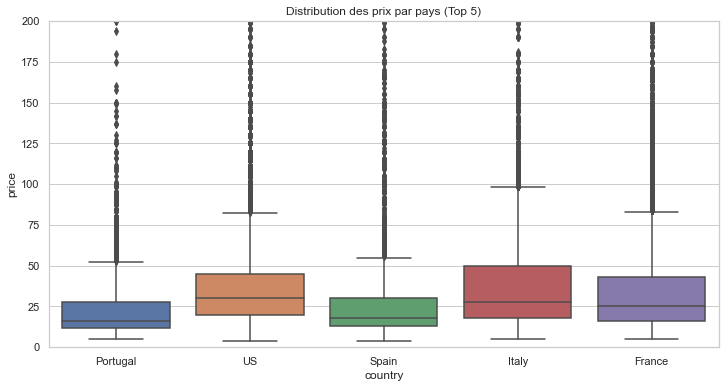

In [ ]:

top_countries = data['country'].value_counts().head(5).index #sélection des 5 pays avec le plus d'entrées
fichier_top_countries = data[data['country'].isin(top_countries)]

plt.figure(figsize=(12, 6))
sns.boxplot(x='country', y='price', data=fichier_top_countries)
plt.ylim(0, 200) #limitation de l'axe y pour une meilleure visibilité de la médiane
plt.title('Distribution des prix par pays (Top 5)')
plt.show()

D'après le graphique, on remarque qu'on ne peut pas traiter tous les vins de la même manière. Le prix varie selon le pays. Par exemple, les vins espagnols sont en majorité plus chèrs que les vins portuguais. Le prix moyen d'une bouteille est de 75$ en Espagne tandis qu'il est de 25$ au Portugal.
( Nous allons donc nous concentrer sur les gros producteurs et probablement devoir transformer la variable prix (log) pour que notre modèle fonctionne.)

### III. Modélisation 1 : régression prix/qualité 

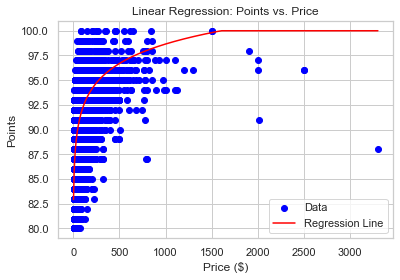

(78.9814187766426, 2.8481142732266598)

In [ ]:
csv_file='data_cleaned.csv'
data=pd.read_csv(csv_file)


def regression_log(x,y):

    log_x = np.log(x) #on prend le logarithme des valeurs de x (prix) pour faire une régression linéaire
    
    coefficients = np.polyfit(log_x, y, 1) #régression linéaire entre points et log(prix)
    
    b = coefficients[0] #pente
    a = coefficients[1] #ordonnée à l'origine

    
    x_range = np.linspace(x.min(), x.max(), 500) #plage de valeurs pour le tracé de la ligne de régression
    y_fit = a + b * np.log(x_range) #equation de la ligne de régression

    for i in range(len(y_fit)):
        if y_fit[i] > 100:
            y_fit[i] = 100  #limitation des valeurs de y_fit à 100 (maximum des points)


    # Tracé des points et de la ligne de régression
    plt.scatter(x, y, color='blue', label='Data')
    plt.plot(x_range, y_fit, color='red', label='Regression Line')
    plt.xlabel('Price ($)')
    plt.ylabel('Points')
    plt.title('Linear Regression: Points vs. Price')
    plt.legend()
    plt.show()

    return a, b

x = data['price'].values
y = data['points'].values
regression_log(x,y)

#### Interprétations : 
On voit d'après le graphique que....

IA a rediger


1. Que représente a (l'ordonnée à l'origine) ?

    Définition mathématique : C'est la valeur de y quand ln(x)=0 (c'est-à-dire quand le prix x=1).

    Interprétation concrète : C'est le "score de base" théorique d'un vin très bon marché (1$).

    Dans vos données : Avec votre résultat précédent (a≈81.05), cela signifie que le modèle estime qu'un vin premier prix commence avec une note de base d'environ 81 points.

2. Que représente b (la pente logarithmique) ?

    Définition mathématique : C'est le taux de variation de la note par rapport au logarithme du prix.

    Interprétation concrète : Il mesure la vitesse à laquelle la note augmente lorsque le prix augmente.

        Si vous multipliez le prix par environ 2,7 (le nombre e), la note augmente de b points.

        Règle simplifiée : Une augmentation du prix de 1% entraîne une augmentation de la note d'environ b/100 points.

    Dans vos données : Avec b≈2.68, une augmentation de 10% du prix se traduit par environ +0.26 point. Pour gagner 2.7 points supplémentaires, il faut multiplier le prix par 2.7.

Conclusions que vous pouvez tirer

    La loi des rendements décroissants : C'est la conclusion la plus importante d'une régression logarithmique. Comme la courbe s'aplatit au fur et à mesure que le prix augmente, cela signifie qu'il devient de plus en plus coûteux d'obtenir des points supplémentaires.

        Passer d'un vin à 10$ à un vin à 20$ aura un impact majeur sur la qualité perçue.

        Passer d'un vin à 100$ à un vin à 110$ (même différence de 10$) n'aura quasiment aucun impact visible sur la note.

    Qualité "plancher" : La valeur de a (81 points) suggère que même les vins les moins chers de votre base de données conservent un certain standard de qualité acceptable (ils ne tombent pas à 0).

    Évaluation du "bon plan" :

        Si un point est au-dessus de la ligne rouge : Le vin est "meilleur que prévu" pour son prix (excellent rapport qualité/prix).

        Si un point est en-dessous de la ligne rouge : Le vin est "trop cher" par rapport à sa qualité théorique.

    Lien de causalité : Le coefficient b positif confirme une corrélation positive : payer plus cher garantit statistiquement une meilleure note, mais avec une efficacité qui diminue rapidement.

#### Choix du vin : 
On peut maintenant choisir quel vin nous testons :

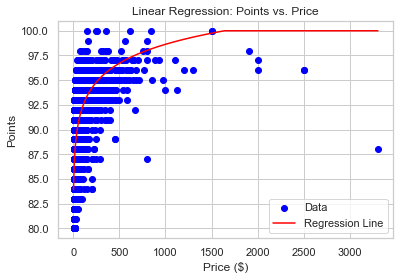

(79.46664454590066, 2.773948314340544)

In [ ]:
#quelques pays à tester
liste_pays=['France', 'Italy', 'US', 'Spain', 'Portugal']
#changer cette variable pour tester d'autres pays
pays='France'  

#quelques Region de france à tester
liste_provinces=[None,'Bordeaux', 'Champagne', 'Provence', 'Loire Valley', 'Burgundy']
#changer cette variable pour tester d'autres régions
province=liste_provinces[0]


def origine(data,country,province=None):

    x= data['price'].values
    y= data['points'].values

    countries = data['country'].values 
    provinces = data['province'].values

    indice_1=countries==country #filtrage par pays
    
    if province is None or province == "": #filtrage par province si spécifiée
        indice_2 = np.ones_like(provinces, dtype=bool)
    else:
        indice_2 = (provinces == province)


    valid_indices =  indice_1 & indice_2 #masque des indices valides
    x = x[valid_indices]
    y = y[valid_indices]


    if len(x) < 2: #minimum de points requis pour la régression
        print(f"Erreur : Pas assez de données pour {country} {province if province else ''} ({len(x)} points trouvés).")
        return None, None
  

    return regression_log(x, y)

path='data_cleaned.csv'
data = pd.read_csv(path)

origine(data,pays,province)

## Modélisation 2 : Le bon plan ;)

### Partie 1: Rapport qualité/prix

- C'est la partie qui nous interesse... on cherche quel vin a le meilleur rapport qualité/prix.

On peut définir un "bon plan" comme un vin dont la note est significativement supérieure à ce que le modèle prédit pour son prix. Par exemple, si un vin à 30$ obtient une note de 92 alors que le modèle prédit seulement 88, c'est un bon plan de 4 points. Forcement plus le prix est eleve, plus le vin sera bon, pour un bon plans a point egaux.

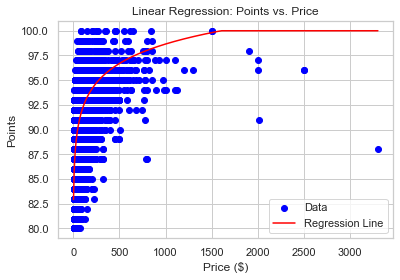

les bons plans:
Prix = $20.00, Points = 96 (Écart = 8.49), Vin de Italy, description: 
What a delightful wine this is. Loaded with finesse, it opens with lovely scents of red berry, crushed rose, graphite, cooking spice and Alpine herb. The beguiling medium-bodied palate offers sour cherry, raspberry, white pepper and mineral while fresh acidity and polished tannins provide impeccable balance. It's already drinking beautifully but will also provide several more years of pure enjoyment.
Prix = $35.00, Points = 97 (Écart = 7.89), Vin de Italy, description: 
This is the kind of easy Sangiovese that would pair with pasta, gnocchi or pork chops. The wine shows natural freshness and pretty berry nuances. Drei Donà is a landmark estate for the entire Emilia-Romagna region.


In [ ]:
#changez cette selon votre budget
prix_max=40

#changez pour avoir des plus gros bon plans
points=7.8

def bon_plan(data, prix_max, points=5):

    x = data['price'].values
    y = data['points'].values
    country = data['country'].values
    description = data['description'].values

    a,b = regression_log(x, y)

    indices = x <= prix_max #filtrage des vins en dessous du prix maximum
    x = x[indices]
    y = y[indices]

    print('les bons plans:')

    for i in range(len(x)):
        point_estime = a + b * np.log(x[i]) #estimation des points selon le modèle
        ecart = y[i] - point_estime #calcul de l'écart entre les points réels et estimés
        if ecart > points: #verification si l'écart dépasse le seuil
            print(f"Prix = ${x[i]:.2f}, Points = {y[i]} (Écart = {ecart:.2f}), Vin de {country[i]}, description: ")
            print(description[i])

bon_plan(data, prix_max,points)

## Partie 2: Vin le moins cher pour une note donnée

- On  peut aussi trouver quelle bouteille est la moins chère pour une note donnée.

Ce modele compare touts les vins de meme note entre eux et affiche le moins cher. Le modele affiche seulement un vin par note. Il peut avoir plusieurs vins au meme prix et meme note, mais pour ne pas surcharger l'affichage, on n'en affiche qu'un seul.


In [ ]:
data=pd.read_csv('data_cleaned.csv')

x = data['price'].values
y = data['points'].values

#Formatage de l'affichage des résultats
header = f"{'NOTE':<5} | {'PRIX':>8} | {'DOMAINE (Winery)':<30} | {'VARIÉTÉ':<20} | {'PAYS':<15} | {'ID':<6}"
print(header)
print("-" * len(header))

for i in range(min(y),max(y)+1):

    vins= data[data['points'] == i] #filtrage des vins avec la note i

    prix_min = vins['price'].min() #calcul du prix minimum pour cette note

    vin_le_moins_cher = vins[vins['price'] == prix_min]

    print(f"{i:<5} | {prix_min:>6.2f} $ | {vin_le_moins_cher['winery'].iloc[0]:<30} | {vin_le_moins_cher['variety'].iloc[0]:<20} | {vin_le_moins_cher['country'].iloc[0]:<15} | {vin_le_moins_cher['id'].iloc[0]} ")

NOTE  |     PRIX | DOMAINE (Winery)               | VARIÉTÉ              | PAYS            | ID    
---------------------------------------------------------------------------------------------------
80    |   5.00 $ | Terrenal                       | Malbec               | Argentina       | 23437 
81    |   5.00 $ | Viña Decana                    | Tempranillo          | Spain           | 33381 
82    |   4.00 $ | Felix Solis                    | White Blend          | Spain           | 117303 
83    |   4.00 $ | Pam's Cuties                   | Chardonnay           | US              | 59507 
84    |   4.00 $ | Broke Ass                      | Malbec-Syrah         | Argentina       | 29553 
85    |   4.00 $ | Felix Solis                    | Syrah                | Spain           | 1987 
86    |   4.00 $ | Bandit                         | Merlot               | US              | 64590 
87    |   5.00 $ | In Situ                        | Sauvignon Blanc      | Chile           | 24592 


## Conclusion

Dans ce projet, nous avons exploré la relation entre le prix et la qualité des vins à travers une analyse de données approfondie. Nous avons constaté que, bien qu'il existe une corrélation positive entre le prix et la note attribuée par les experts, cette relation suit une loi de rendements décroissants. En d'autres termes, augmenter le prix d'un vin n'entraîne pas toujours une amélioration proportionnelle de sa qualité perçue.

De plus la note reste un facteur subjectif, influencé par des préférences personnelles, des tendances culturelles et des biais de dégustation. Ainsi, bien que notre modèle fournisse une estimation statistique utile, il ne peut capturer toutes les nuances de l'expérience de dégustation.

La validité de ces notes doit être questionnée : elles reflètent les jugements de dégustateurs humains susceptibles d'être biaisés par des considérations commerciales ou personnelles.

Mais pour nous, simple amateur de vin, ce modèle nous offre un outil simple pour avoir une premier estimation du rapport qualité/prix d'une bouteille avant de l'acheter et de découvrir des nouveaux vins.